# Auto-tuning Kalman Filter on a recorded 2D Fly Trajectory

In [1]:
import numpy as np
np.random.seed(10015)
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

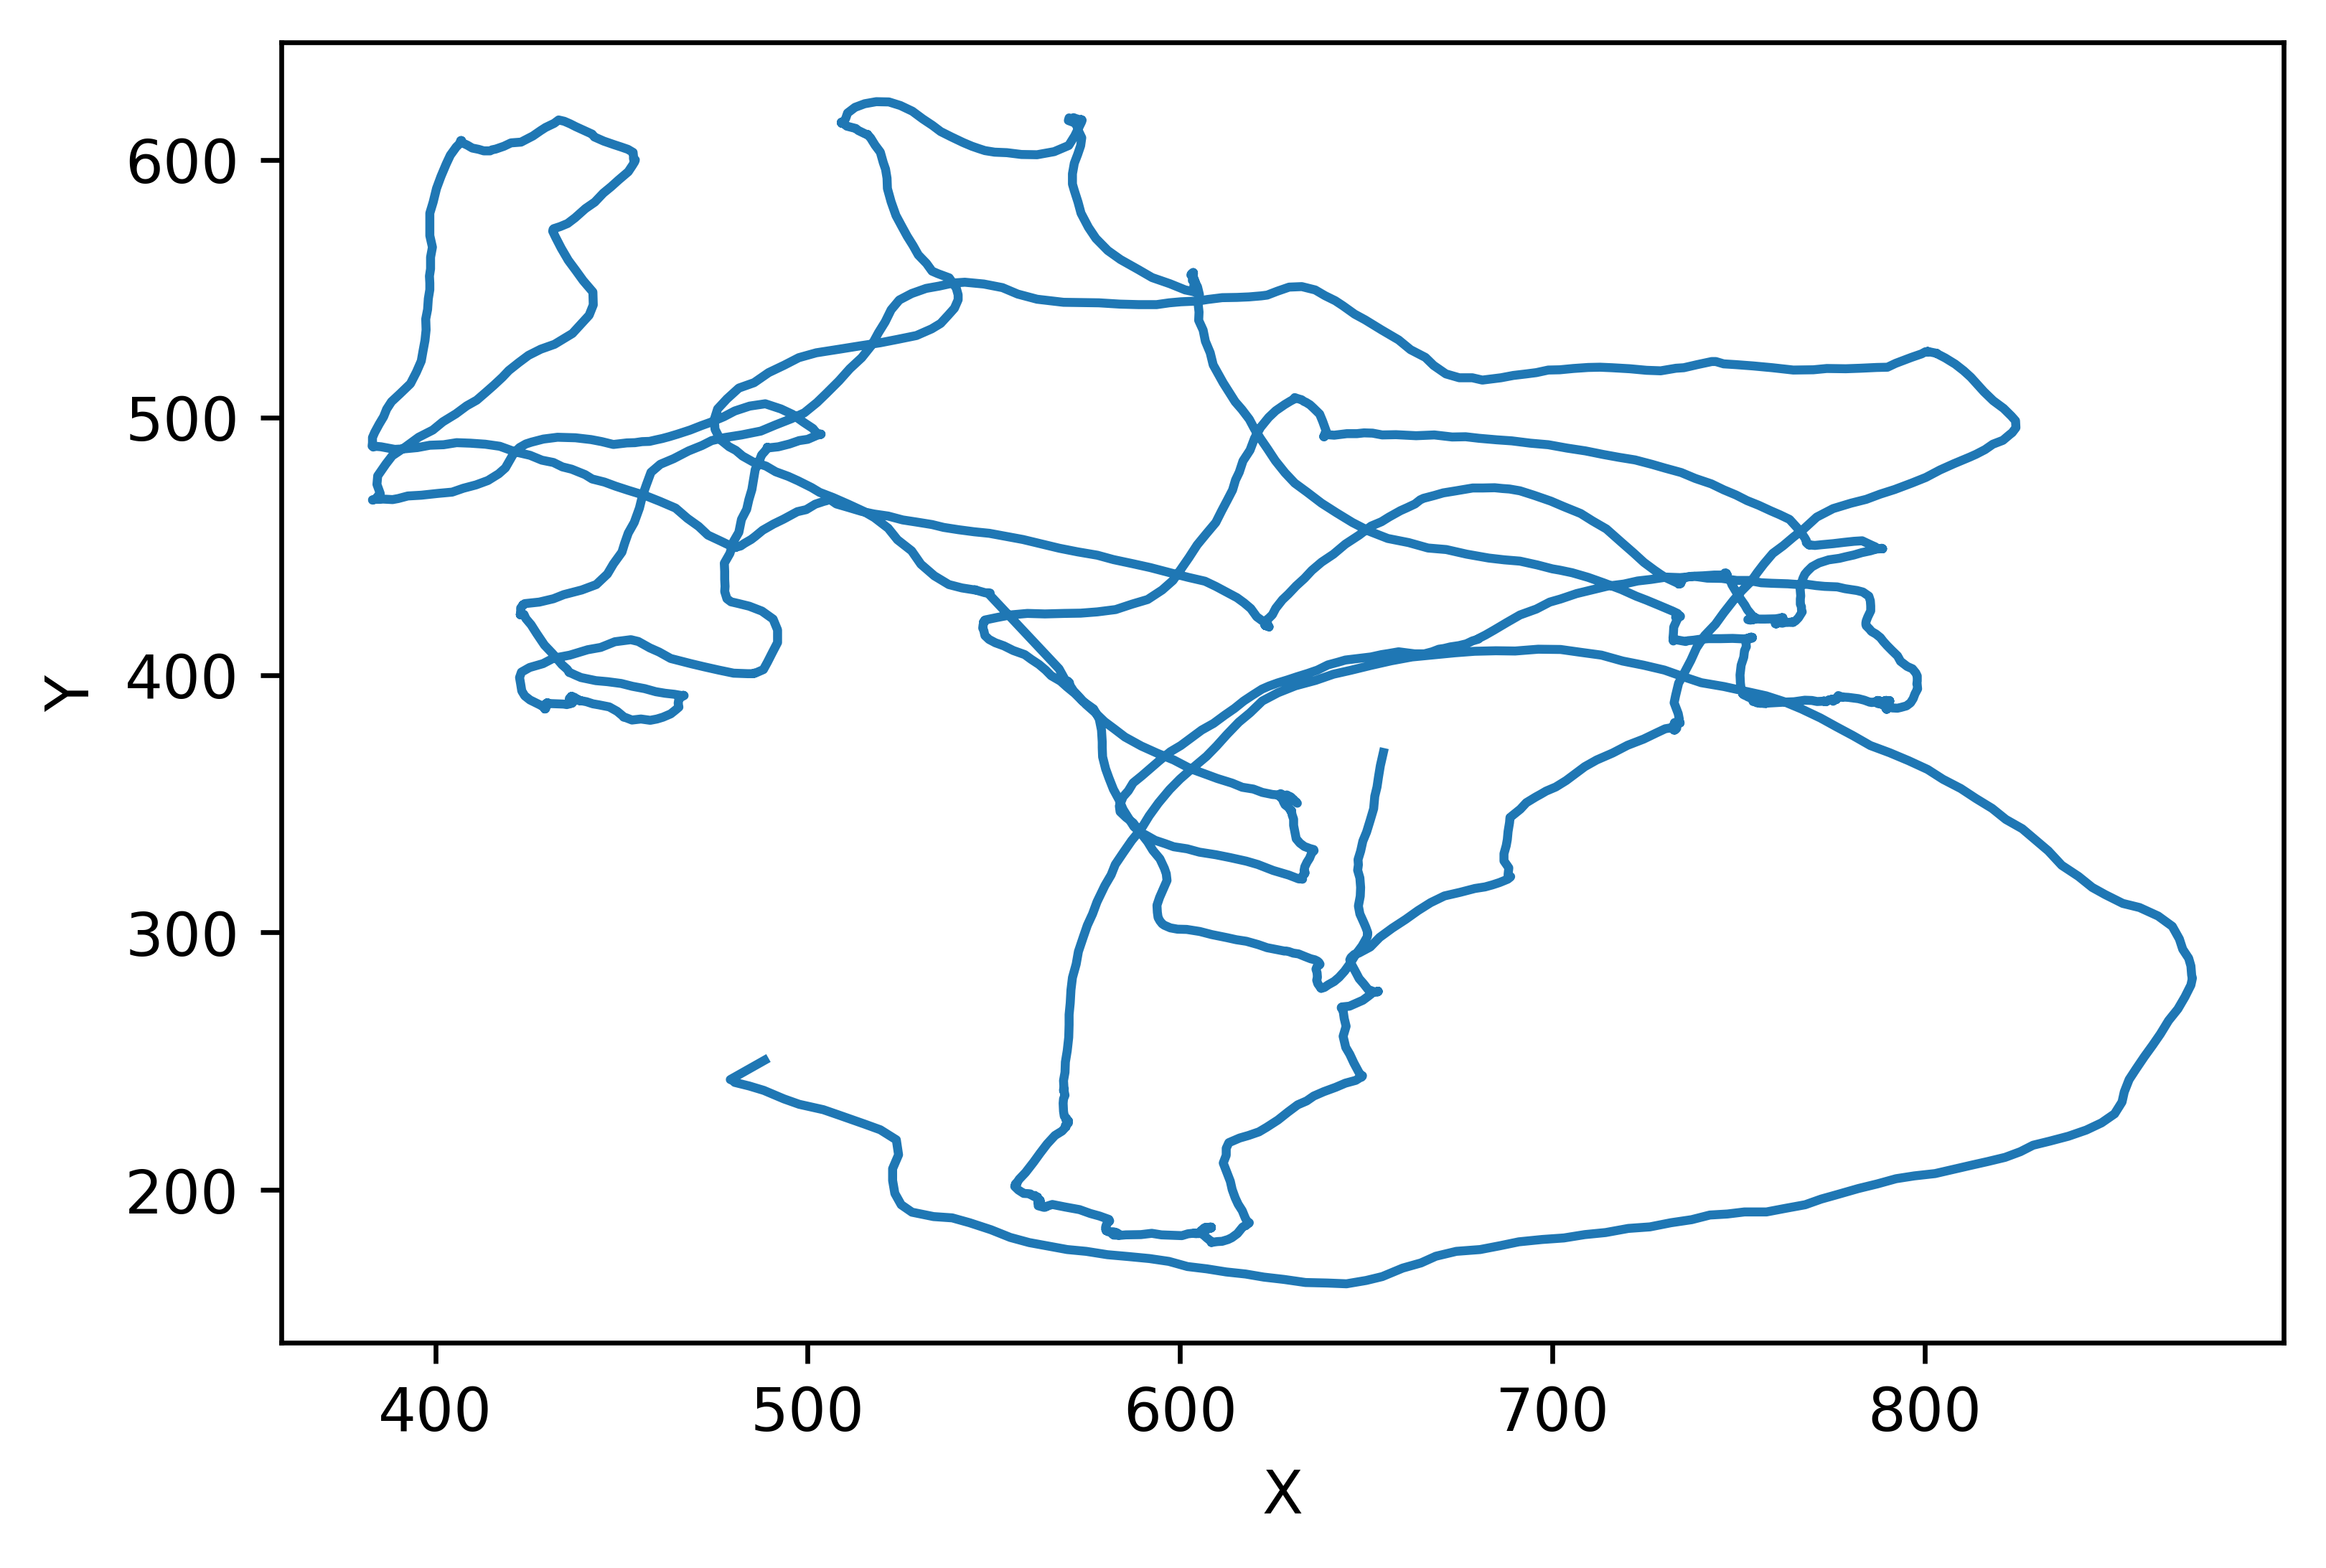

In [2]:
# Load a 2D fly trajectory.
df = pd.read_csv('./data/example_trajectory.csv', comment='#')
# Add time.
df['time'] = 1e-6 * (df['time_microseconds'] - df['time_microseconds'].iloc[0])
dt = np.mean(np.diff(df['time']))

# Plot trajectory
fig = plt.figure(dpi=600)
plt.plot(df['x_px'], df['y_px'])
plt.xlabel('X');
plt.ylabel('Y');

In [3]:
# Build the Kalman filter tuning model.
from utils import KalmanFilterTuningModel

F = np.array([
    [1, dt, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, dt],
    [0, 0, 0, 1]
])

H = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0]
])

initial_state = np.array([[df.loc[0, 'x_px'], 0, df.loc[0, 'y_px'], 0]]).T
P = 1000.0*np.eye(4)

obs_traj = np.array([df['x_px'], df['y_px']]).T

tuning_model = KalmanFilterTuningModel(dim_x=4, dim_z=2, 
                                      F=F, 
                                      H=H, 
                                      initial_state=initial_state, 
                                      P=P, 
                                      observation=obs_traj)

In [10]:
# Build the optimizer.
from hyperopt import hp, fmin, rand, tpe, space_eval
from filterpy.common import Q_discrete_white_noise
from scipy.linalg import block_diag

# Set Object function.
def J(args):
    q_var, r_var = args
    Q = q_var * np.array([
    [dt ** 3 / 3, dt ** 2 / 2, 0, 0], 
    [dt ** 2 / 2, dt, 0, 0], 
    [0, 0, dt ** 3 / 3, dt ** 2 / 2], 
    [0, 0, dt ** 2 / 2, dt]
])
    R = np.eye(2) * r_var
    nis_loss = tuning_model.get_filter_nis_loss(Q, R)
    return nis_loss

# Set parameter space for searching.
param_space = [
    hp.uniform('q_var', 0, 10000),
    hp.uniform('r_var', 0, 1)
]

optimal_param = fmin(J, param_space, algo=tpe.suggest, max_evals=100)

100%|█████████████████████████| 100/100 [00:35<00:00,  2.86trial/s, best loss: 0.003130034622180159]


In [11]:
print('Optimal parameters:\n q_var: {}\n r_var: {}'.format(optimal_param['q_var'], optimal_param['r_var']))

Optimal parameters:
 q_var: 1534.4616396282036
 r_var: 0.8723286674918517


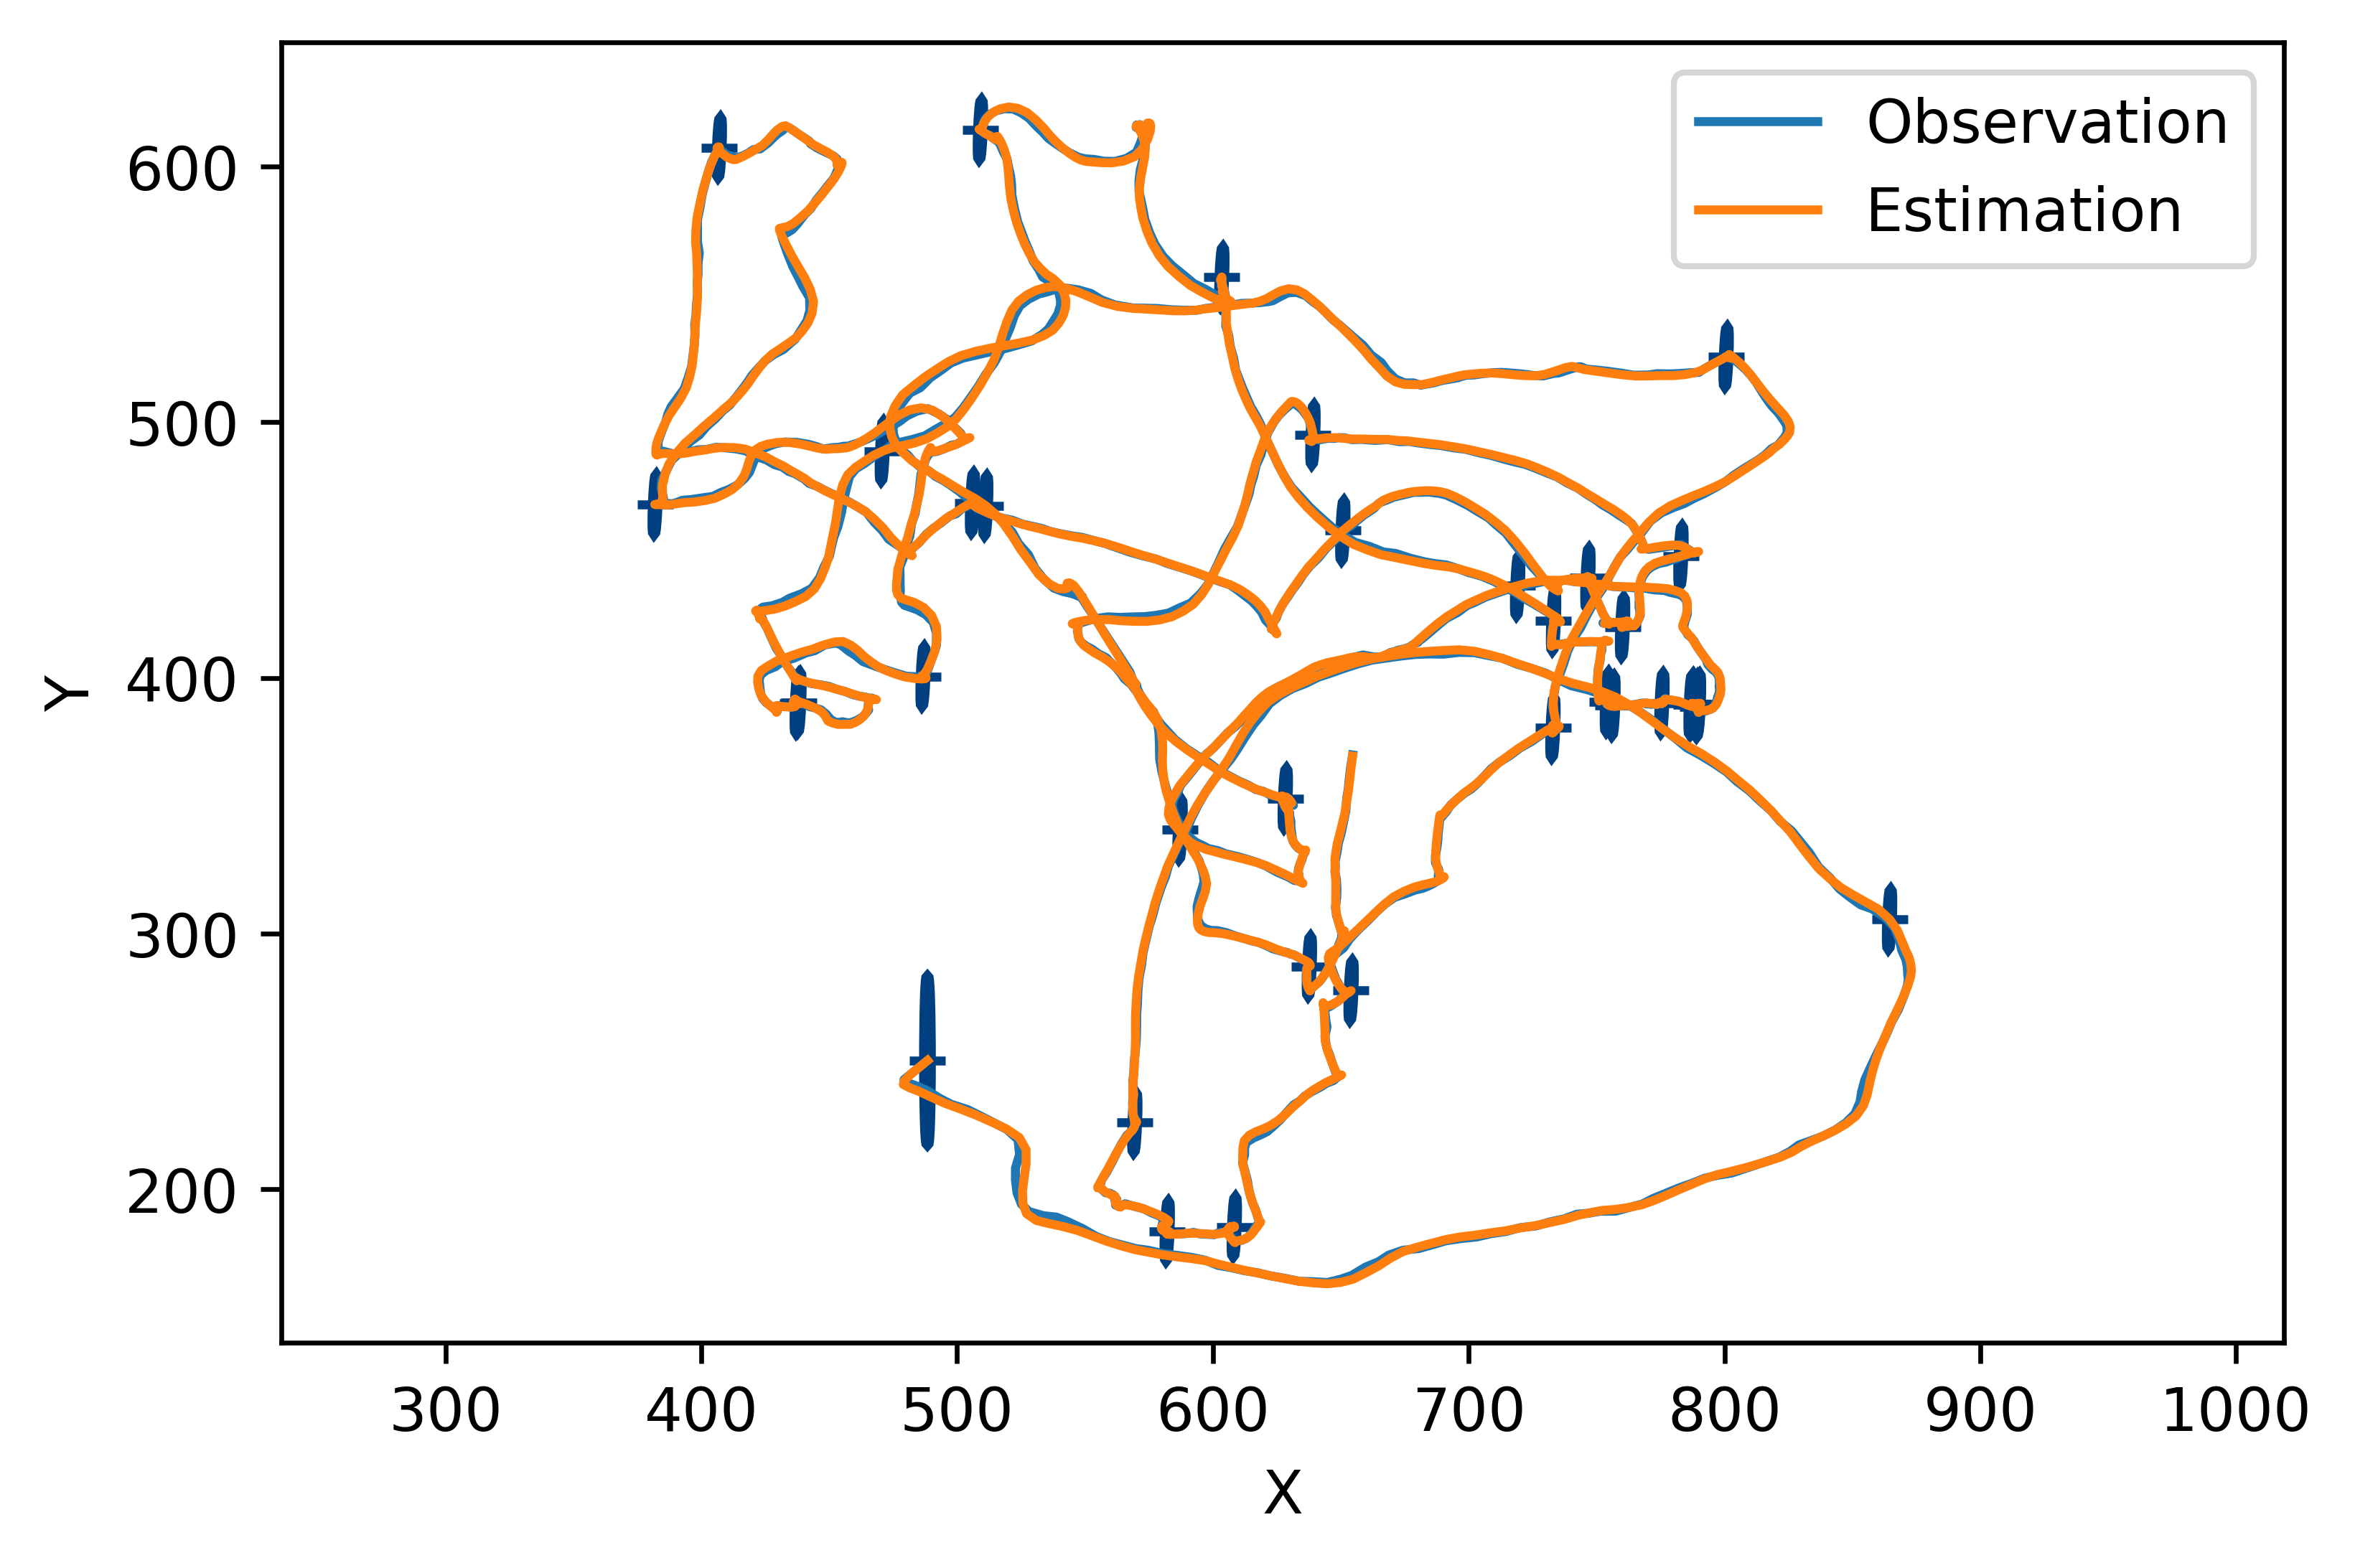

In [12]:
# Build a Kalman filter using the optimal Q and R.
from filterpy.kalman import KalmanFilter
from filterpy.stats import plot_covariance

kalman_filter = KalmanFilter(dim_x=4, dim_z=2)
kalman_filter.F = F
kalman_filter.H = H
kalman_filter.x = initial_state
kalman_filter.P = P

best_q_var = optimal_param['q_var']
best_r_var = optimal_param['r_var']
kalman_filter.Q = best_q_var * np.array([
    [dt ** 3 / 3, dt ** 2 / 2, 0, 0], 
    [dt ** 2 / 2, dt, 0, 0], 
    [0, 0, dt ** 3 / 3, dt ** 2 / 2], 
    [0, 0, dt ** 2 / 2, dt]
])
kalman_filter.R = np.eye(2) * best_r_var

estimate_traj_mu, estimate_traj_cov, _, _ = kalman_filter.batch_filter(obs_traj)

# Draw the estimated trajectory with optimal filter parameters.
fig = plt.figure(dpi=600)
plt.plot(df['x_px'], df['y_px'], linestyle='-', label='Observation')
plt.plot(estimate_traj_mu.reshape(-1, 4)[:, 0], estimate_traj_mu.reshape(-1, 4)[:, 2], 
         linestyle='-', label='Estimation')
plt.legend()
plt.xlabel('X');
plt.ylabel('Y');

for i in range(0, estimate_traj_cov.shape[0], 100):
    plot_covariance((estimate_traj_mu.reshape(-1, 4)[i, 0], estimate_traj_mu.reshape(-1, 4)[i, 2]), 
                    estimate_traj_cov[i, :2, :2])